In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
import copy
from torchvision.transforms import Compose, RandomCrop, ToTensor, Normalize
import random
import matplotlib.cm as cm
from torchvision.transforms import ToPILImage, GaussianBlur
import h5py
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super().__init__()
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=7, padding=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=7, padding=3)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=7, padding=3)
        self.conv5 = nn.Conv2d(32, out_channels, kernel_size=7, padding=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        return x
    

# U-Net with ResNet backbone
class UNetResNet(nn.Module):
    def __init__(self, num_classes):
        super(UNetResNet, self).__init__()
        
        # ResNet backbone
        self.resnet = models.resnet34(pretrained=True)
        
        # Adjust the first convolutional layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Encoder
        self.encoder1 = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool
        )
        self.encoder2 = self.resnet.layer1
        self.encoder3 = self.resnet.layer2
        self.encoder4 = self.resnet.layer3
        self.encoder5 = self.resnet.layer4
        
        # Decoder
        self.decoder4 = self._make_decoder_block(512, 256, 256)
        self.decoder3 = self._make_decoder_block(512, 128, 128)
        self.decoder2 = self._make_decoder_block(256, 64, 64)
        self.decoder1 = self._make_decoder_block(128, 64, 64, s=4)
        
        # Final convolutional layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def _make_decoder_block(self, in_channels, mid_channels, out_channels, s=2):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, mid_channels, kernel_size=2, stride=s),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)
        
        
        # Decoder with residual connections
        dec4 = self.decoder4(enc5)
        dec3 = self.decoder3(torch.cat([dec4, enc4], dim=1))
        dec2 = self.decoder2(torch.cat([dec3, enc3], dim=1))
        dec1 = self.decoder1(torch.cat([dec2, enc2], dim=1))
        
        # Final convolutional layer
        output = self.final_conv(dec1)
        
        # Reshape output to match input dimensions
        output = nn.functional.interpolate(output, size=x.shape[2:], mode='bilinear', align_corners=False)
        
        return output

In [3]:
# Define the input and output directories
train_directory = r'data\000_WorkingFiles\CNNTrain\train\\'
val_directory = r'data\000_WorkingFiles\CNNTrain\val\\'
output_directory = r'data\000_WorkingFiles\CNNTrain\out\\'

In [4]:
# Define the desired output size
output_size = 1024

# Define the transformations for data augmentation
transform = transforms.Compose([
    transforms.RandomCrop(output_size),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Create a custom dataset
class MyDataset(Dataset):
    def __init__(self, input_directory, output_directory, transform=None):
        self.input_directory = input_directory
        self.output_directory = output_directory
        self.transform = transform
        self.filenames = os.listdir(input_directory)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        file_name = self.filenames[index]
        input_image_path = os.path.join(self.input_directory, file_name)
        output_image_path = os.path.join(self.output_directory, file_name)

        input_image = Image.open(input_image_path)
        output_image = Image.open(output_image_path)
        
        seed = np.random.randint(2147483647) 
        if self.transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            input_image = self.transform(input_image)
            random.seed(seed)
            torch.manual_seed(seed)
            output_image = self.transform(output_image)
          
        input_image = input_image * 255
        # input_image = np.dstack((input_image,input_image,input_image)) * 255
        # input_image = np.swapaxes(input_image, 2, 0)
        # input_image = np.swapaxes(input_image, 1, 2)
        # output_image = output_image * 255

        tf = np.where(output_image[1,:,:] > 0, 1, 0)
        output_image = np.dstack((tf, 1-tf)).astype(np.uint8)
        output_image = np.swapaxes(output_image, 2, 0)
        output_image = np.swapaxes(output_image, 1, 2)
        
        
        
        return input_image, output_image, self.filenames

# Create the output directory if it does not exist
# os.makedirs(output_directory, exist_ok=True)

# Create the dataset and data loader
dataset = MyDataset(train_directory, output_directory, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset = MyDataset(val_directory, output_directory, transform=transform)
val_loader = DataLoader(dataset, batch_size=32, shuffle=True)

C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:3077: DecompressionBombWarning: Image size (151368000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


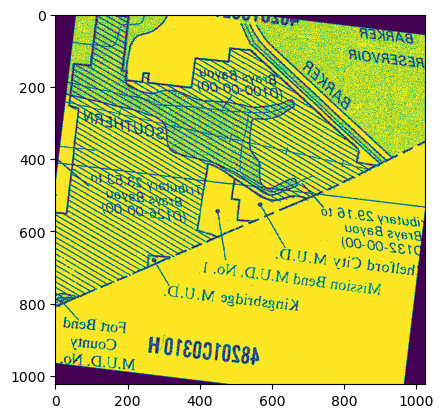

torch.Size([1, 1, 1024, 1024])
torch.Size([1, 2, 1024, 1024])


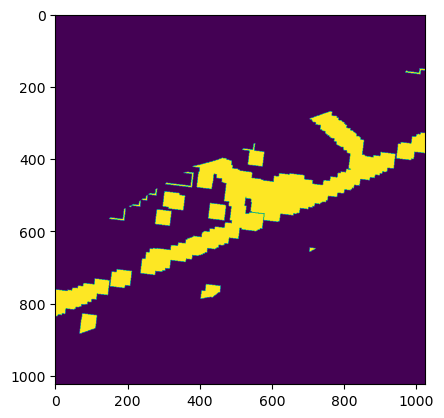

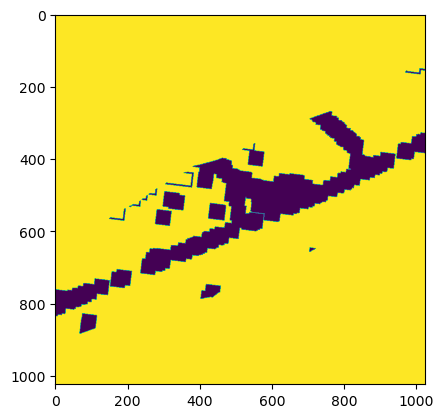

In [5]:

for batch_input, batch_output, filenames in train_loader:
    plt.imshow(batch_input[0, :, :, :].squeeze())
    plt.show()
    print(batch_input.shape)
    print(batch_output.shape)
    plt.imshow(batch_output[0,0,:,:])
    plt.show()
    plt.imshow(batch_output[0,1,:,:])

In [6]:
def train(model, dataloaders, num_epochs=20, 
          output_dir=r'data\000_WorkingFiles\CNNTrain\intermediate_outputs', 
          learning_rate=5e-4,
          continuefrom="checkpoint.pth"):
    device = torch.device("cuda:0")
    weights = torch.tensor([200, 1]).float().to(device)
    # criterion = nn.MSELoss()
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    # criterion = MaskedCrossEntropy(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.96)
    
    model = model.to(device)
    # since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']: 
            if phase == 'train':
                model.train()
                repeats = range(32)
            else:
                model.eval()
                repeats = range(2)

            running_loss = 0.0
            
            outputs_folder = os.path.join(output_dir, phase)
            if not os.path.exists(outputs_folder):
                os.makedirs(outputs_folder)
                
            curr_loss = 0
            
            # Iterate over data.
            for rep_id in tqdm(repeats):
                for batch_input, batch_output, filenames in dataloaders[phase]:
                    batch_input = batch_input.to(device)
                    batch_output = batch_output.float().to(device)

                    optimizer.zero_grad()
                    outputs = model(batch_input)
                    
                    
                    loss = criterion(outputs, batch_output)
                    curr_loss = loss + curr_loss 
                    if rep_id % 4 == 0 and phase is 'train' and rep_id != 0:
                        print(f"{curr_loss:.4e} {curr_loss/4:.4e}")
                        curr_loss = 0
                        
                        
                        for i in range(len(outputs)):
                            filename = filenames[i]
                            prob_img = np.squeeze(outputs.detach().cpu().numpy()[0, 0, :, :]).astype(np.uint8)
                            #print(prob_img)
                            prob_img = Image.fromarray(np.squeeze(prob_img))
                            #plt.imshow(prob_img)
                            #plt.show()
                            prob_img.save(os.path.join(outputs_folder, f"{rep_id}_{filename}.png"))
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        for i in range(len(outputs)):
                            filename = filenames[i]
                            prob_img = np.squeeze(outputs.detach().cpu().numpy()[0, 0, :, :]).astype(np.uint8)
                            #print(prob_img)
                            prob_img = Image.fromarray(np.squeeze(prob_img))
                            #plt.imshow(prob_img)
                            #plt.show()
                            prob_img.save(os.path.join(outputs_folder, f"{rep_id}_{filename}.png"))

                    running_loss += loss.item() 

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'val' and epoch_loss < best_acc:
                best_model_wts = copy.deepcopy(model.state_dict())
        # Update the learning rate scheduler after each epoch
        learning_rate_scheduler.step()
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
        # Save the model and optimizer states
        if epoch % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 'checkpoint.pth')
            
            torch.save(model, r"preprocess.pth")
        
    return model

In [7]:
model = UNetResNet(2)
loaders = {'train' : train_loader, 'val' : val_loader}
model = train(model, loaders, num_epochs=1000, learning_rate=1e-3)

C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.4224e+01 1.1056e+01
2.6349e+01 6.5873e+00
1.3801e+01 3.4503e+00
1.1569e+01 2.8921e+00
1.2787e+01 3.1967e+00
2.1964e+01 5.4910e+00
1.4425e+01 3.6062e+00
train Loss: 156.6136


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:3077: DecompressionBombWarning: Image size (120780563 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


val Loss: 7.1801
Learning Rate: 0.001
Epoch 2/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

2.1104e+01 5.2759e+00
1.3366e+01 3.3416e+00
1.1180e+01 2.7951e+00
1.5844e+01 3.9611e+00
9.5390e+00 2.3847e+00
1.1581e+01 2.8952e+00
9.7393e+00 2.4348e+00
train Loss: 100.3860


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 9.5289
Learning Rate: 0.001
Epoch 3/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.3355e+01 3.3388e+00
8.3616e+00 2.0904e+00
1.1349e+01 2.8372e+00
1.1188e+01 2.7970e+00
7.9528e+00 1.9882e+00
9.5376e+00 2.3844e+00
1.0410e+01 2.6025e+00
train Loss: 79.2732


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 8.4661
Learning Rate: 0.001
Epoch 4/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.5498e+01 3.8745e+00
1.2125e+01 3.0313e+00
1.0201e+01 2.5502e+00
1.0124e+01 2.5310e+00
1.1143e+01 2.7857e+00
7.4049e+00 1.8512e+00
8.3406e+00 2.0851e+00
train Loss: 82.2290


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 8.0350
Learning Rate: 0.001
Epoch 5/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.3036e+01 3.2589e+00
8.0010e+00 2.0003e+00
8.4945e+00 2.1236e+00
1.0346e+01 2.5866e+00
8.7152e+00 2.1788e+00
7.0790e+00 1.7697e+00
8.8099e+00 2.2025e+00
train Loss: 69.2129


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.1627
Learning Rate: 0.001
Epoch 6/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.5169e+00 1.8792e+00
9.4827e+00 2.3707e+00
7.2864e+00 1.8216e+00
1.0502e+01 2.6255e+00
8.9245e+00 2.2311e+00
1.0843e+01 2.7108e+00
7.2312e+00 1.8078e+00
train Loss: 67.0249


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 8.1246
Learning Rate: 0.001
Epoch 7/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.1761e+01 2.9403e+00
8.4649e+00 2.1162e+00
6.4183e+00 1.6046e+00
7.0933e+00 1.7733e+00
5.2458e+00 1.3114e+00
6.6974e+00 1.6744e+00
4.2272e+00 1.0568e+00
train Loss: 60.9888


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.7186
Learning Rate: 0.001
Epoch 8/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.2271e+01 3.0678e+00
9.2146e+00 2.3037e+00
9.8381e+00 2.4595e+00
8.7670e+00 2.1918e+00
7.4020e+00 1.8505e+00
7.4349e+00 1.8587e+00
5.3840e+00 1.3460e+00
train Loss: 68.4312


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.2856
Learning Rate: 0.001
Epoch 9/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.4488e+01 3.6221e+00
8.7697e+00 2.1924e+00
1.0195e+01 2.5488e+00
7.3452e+00 1.8363e+00
6.5292e+00 1.6323e+00
5.1269e+00 1.2817e+00
7.7551e+00 1.9388e+00
train Loss: 63.8346


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.5166
Learning Rate: 0.001
Epoch 10/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.5272e+00 2.1318e+00
9.8504e+00 2.4626e+00
5.8360e+00 1.4590e+00
8.4206e+00 2.1052e+00
8.2704e+00 2.0676e+00
3.3274e+00 8.3184e-01
8.1608e+00 2.0402e+00
train Loss: 57.7444


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.6507
Learning Rate: 0.00096
Epoch 11/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.6288e+00 1.9072e+00
1.1212e+01 2.8031e+00
7.9425e+00 1.9856e+00
9.6375e+00 2.4094e+00
6.9284e+00 1.7321e+00
6.4188e+00 1.6047e+00
6.7067e+00 1.6767e+00
train Loss: 61.8417


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 7.4661
Learning Rate: 0.00096
Epoch 12/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

9.7844e+00 2.4461e+00
3.9648e+00 9.9120e-01
6.3300e+00 1.5825e+00
5.7617e+00 1.4404e+00
5.5866e+00 1.3966e+00
1.0282e+01 2.5706e+00
7.3507e+00 1.8377e+00
train Loss: 55.9622


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 4.4826
Learning Rate: 0.00096
Epoch 13/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.7719e+00 2.1930e+00
4.1565e+00 1.0391e+00
5.4210e+00 1.3552e+00
5.4148e+00 1.3537e+00
7.6592e+00 1.9148e+00
8.0175e+00 2.0044e+00
9.0898e+00 2.2724e+00
train Loss: 53.8900


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 11.2457
Learning Rate: 0.00096
Epoch 14/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.0171e+01 2.5428e+00
7.6363e+00 1.9091e+00
5.4697e+00 1.3674e+00
6.0159e+00 1.5040e+00
6.2304e+00 1.5576e+00
3.8824e+00 9.7061e-01
6.1831e+00 1.5458e+00
train Loss: 49.9804


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 6.9861
Learning Rate: 0.00096
Epoch 15/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.4305e+00 2.1076e+00
7.3215e+00 1.8304e+00
8.1242e+00 2.0311e+00
5.2716e+00 1.3179e+00
6.0756e+00 1.5189e+00
5.2024e+00 1.3006e+00
6.7003e+00 1.6751e+00
train Loss: 52.4700


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9879
Learning Rate: 0.00096
Epoch 16/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.3035e+00 1.8259e+00
3.4054e+00 8.5135e-01
4.5701e+00 1.1425e+00
7.9166e+00 1.9791e+00
4.8013e+00 1.2003e+00
6.3613e+00 1.5903e+00
3.2453e+00 8.1133e-01
train Loss: 41.4877


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.3324
Learning Rate: 0.00096
Epoch 17/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

9.0965e+00 2.2741e+00
8.2744e+00 2.0686e+00
5.3113e+00 1.3278e+00
6.9866e+00 1.7466e+00
3.6896e+00 9.2239e-01
1.0914e+01 2.7284e+00
5.2002e+00 1.3001e+00
train Loss: 55.0090


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.3642
Learning Rate: 0.00096
Epoch 18/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.9497e+00 1.7374e+00
3.8149e+00 9.5373e-01
6.2002e+00 1.5500e+00
7.1206e+00 1.7801e+00
4.0487e+00 1.0122e+00
1.1566e+01 2.8916e+00
6.4506e+00 1.6126e+00
train Loss: 51.9744


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 4.8076
Learning Rate: 0.00096
Epoch 19/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.9617e+00 1.4904e+00
6.2776e+00 1.5694e+00
8.2725e+00 2.0681e+00
4.1972e+00 1.0493e+00
9.2831e+00 2.3208e+00
7.5157e+00 1.8789e+00
3.9525e+00 9.8813e-01
train Loss: 48.5138


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8137
Learning Rate: 0.00096
Epoch 20/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.1986e+00 1.7997e+00
4.1361e+00 1.0340e+00
5.9610e+00 1.4903e+00
5.0761e+00 1.2690e+00
6.0779e+00 1.5195e+00
8.6797e+00 2.1699e+00
5.3143e+00 1.3286e+00
train Loss: 46.9317


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.0100
Learning Rate: 0.0009216
Epoch 21/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.6026e+00 2.1507e+00
1.4712e+00 3.6781e-01
3.9010e+00 9.7525e-01
6.8261e+00 1.7065e+00
4.7588e+00 1.1897e+00
7.0328e+00 1.7582e+00
3.4020e+00 8.5049e-01
train Loss: 41.0218


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 4.6081
Learning Rate: 0.0009216
Epoch 22/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.6015e+00 2.1504e+00
5.7559e+00 1.4390e+00
3.3895e+00 8.4738e-01
6.0109e+00 1.5027e+00
2.6037e+00 6.5092e-01
3.4008e+00 8.5021e-01
9.7251e+00 2.4313e+00
train Loss: 42.5894


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.4474
Learning Rate: 0.0009216
Epoch 23/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.8281e+00 1.2070e+00
7.6877e+00 1.9219e+00
7.3145e+00 1.8286e+00
4.9672e+00 1.2418e+00
5.4089e+00 1.3522e+00
5.8722e+00 1.4681e+00
5.0628e+00 1.2657e+00
train Loss: 46.3139


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6923
Learning Rate: 0.0009216
Epoch 24/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.5010e+00 1.6253e+00
2.5062e+00 6.2654e-01
1.2702e+01 3.1755e+00
7.6971e+00 1.9243e+00
7.8761e+00 1.9690e+00
9.7242e+00 2.4310e+00
8.3749e+00 2.0937e+00
train Loss: 60.5270


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.4308
Learning Rate: 0.0009216
Epoch 25/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.7045e+00 2.1761e+00
7.8998e+00 1.9750e+00
7.4077e+00 1.8519e+00
5.1800e+00 1.2950e+00
5.5419e+00 1.3855e+00
5.2474e+00 1.3118e+00
6.0857e+00 1.5214e+00
train Loss: 52.9007


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.1482
Learning Rate: 0.0009216
Epoch 26/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.4842e+00 1.8710e+00
7.7908e+00 1.9477e+00
5.9459e+00 1.4865e+00
6.9413e+00 1.7353e+00
4.2444e+00 1.0611e+00
8.6553e+00 2.1638e+00
8.0787e+00 2.0197e+00
train Loss: 51.1364


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.9330
Learning Rate: 0.0009216
Epoch 27/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.1796e+00 2.0449e+00
7.1684e+00 1.7921e+00
5.4201e+00 1.3550e+00
5.9868e+00 1.4967e+00
4.8596e+00 1.2149e+00
6.0311e+00 1.5078e+00
9.0815e+00 2.2704e+00
train Loss: 51.9694


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.7299
Learning Rate: 0.0009216
Epoch 28/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.5829e+00 1.6457e+00
6.2878e+00 1.5720e+00
6.2369e+00 1.5592e+00
6.0738e+00 1.5185e+00
7.0144e+00 1.7536e+00
4.1915e+00 1.0479e+00
6.8570e+00 1.7142e+00
train Loss: 50.3160


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.3897
Learning Rate: 0.0009216
Epoch 29/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.6120e+00 1.4030e+00
6.9691e+00 1.7423e+00
6.9013e+00 1.7253e+00
6.9533e+00 1.7383e+00
6.1975e+00 1.5494e+00
6.5626e+00 1.6407e+00
6.5694e+00 1.6424e+00
train Loss: 50.0545


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.8057
Learning Rate: 0.0009216
Epoch 30/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

3.5392e+00 8.8479e-01
6.5554e+00 1.6388e+00
9.1024e+00 2.2756e+00
6.7738e+00 1.6935e+00
7.7961e+00 1.9490e+00
5.4336e+00 1.3584e+00
5.9569e+00 1.4892e+00
train Loss: 50.3682


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.5023
Learning Rate: 0.0008847359999999999
Epoch 31/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.7461e+00 1.9365e+00
7.8677e+00 1.9669e+00
7.9735e+00 1.9934e+00
6.6573e+00 1.6643e+00
8.4861e+00 2.1215e+00
5.8643e+00 1.4661e+00
4.5905e+00 1.1476e+00
train Loss: 55.5411


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.5969
Learning Rate: 0.0008847359999999999
Epoch 32/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

9.1605e+00 2.2901e+00
6.2297e+00 1.5574e+00
6.7927e+00 1.6982e+00
4.0989e+00 1.0247e+00
8.6070e+00 2.1518e+00
7.8062e+00 1.9515e+00
6.0102e+00 1.5026e+00
train Loss: 54.5727


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.8059
Learning Rate: 0.0008847359999999999
Epoch 33/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.3791e+00 1.8448e+00
3.7112e+00 9.2780e-01
6.3892e+00 1.5973e+00
5.1333e+00 1.2833e+00
6.2910e+00 1.5727e+00
6.6300e+00 1.6575e+00
5.4242e+00 1.3561e+00
train Loss: 46.4817


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.1664
Learning Rate: 0.0008847359999999999
Epoch 34/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.7018e+00 2.1755e+00
6.4201e+00 1.6050e+00
6.2206e+00 1.5552e+00
5.1773e+00 1.2943e+00
8.0270e+00 2.0067e+00
6.3749e+00 1.5937e+00
5.5333e+00 1.3833e+00
train Loss: 51.7408


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.7647
Learning Rate: 0.0008847359999999999
Epoch 35/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.3300e+00 1.5825e+00
3.7531e+00 9.3828e-01
6.9505e+00 1.7376e+00
6.1639e+00 1.5410e+00
6.2202e+00 1.5550e+00
7.5098e+00 1.8775e+00
4.9778e+00 1.2444e+00
train Loss: 44.7325


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.8774
Learning Rate: 0.0008847359999999999
Epoch 36/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.8868e+00 1.4717e+00
5.2455e+00 1.3114e+00
5.4405e+00 1.3601e+00
7.8943e+00 1.9736e+00
4.9626e+00 1.2406e+00
6.3260e+00 1.5815e+00
4.7321e+00 1.1830e+00
train Loss: 45.1712


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.9584
Learning Rate: 0.0008847359999999999
Epoch 37/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.6951e+00 1.9238e+00
4.7063e+00 1.1766e+00
6.3841e+00 1.5960e+00
6.8173e+00 1.7043e+00
6.9081e+00 1.7270e+00
5.7246e+00 1.4312e+00
7.4825e+00 1.8706e+00
train Loss: 50.0280


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.8110
Learning Rate: 0.0008847359999999999
Epoch 38/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

9.2491e+00 2.3123e+00
7.0605e+00 1.7651e+00
6.7580e+00 1.6895e+00
7.1957e+00 1.7989e+00
7.2845e+00 1.8211e+00
6.6644e+00 1.6661e+00
4.5722e+00 1.1431e+00
train Loss: 53.8332


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.2836
Learning Rate: 0.0008847359999999999
Epoch 39/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.4401e+00 1.6100e+00
4.2095e+00 1.0524e+00
6.0983e+00 1.5246e+00
6.0646e+00 1.5161e+00
3.5621e+00 8.9052e-01
7.2056e+00 1.8014e+00
5.4398e+00 1.3600e+00
train Loss: 43.3163


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.8893
Learning Rate: 0.0008847359999999999
Epoch 40/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.3875e+00 2.0969e+00
4.3267e+00 1.0817e+00
7.9612e+00 1.9903e+00
6.4945e+00 1.6236e+00
3.8794e+00 9.6985e-01
5.9718e+00 1.4930e+00
5.5879e+00 1.3970e+00
train Loss: 47.3676


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.8189
Learning Rate: 0.0008493465599999999
Epoch 41/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.3524e+00 1.5881e+00
5.2971e+00 1.3243e+00
7.3388e+00 1.8347e+00
7.7156e+00 1.9289e+00
5.1742e+00 1.2936e+00
6.4216e+00 1.6054e+00
8.8672e+00 2.2168e+00
train Loss: 50.2963


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.5695
Learning Rate: 0.0008493465599999999
Epoch 42/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.8787e+00 1.2197e+00
7.6426e+00 1.9107e+00
6.0028e+00 1.5007e+00
6.0645e+00 1.5161e+00
6.4420e+00 1.6105e+00
4.5263e+00 1.1316e+00
7.2480e+00 1.8120e+00
train Loss: 48.0162


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.3496
Learning Rate: 0.0008493465599999999
Epoch 43/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.4110e+00 2.1028e+00
3.7616e+00 9.4039e-01
6.4002e+00 1.6000e+00
5.7305e+00 1.4326e+00
9.0501e+00 2.2625e+00
6.1086e+00 1.5271e+00
3.5388e+00 8.8469e-01
train Loss: 47.4749


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.7087
Learning Rate: 0.0008493465599999999
Epoch 44/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.6867e+00 2.1717e+00
6.0765e+00 1.5191e+00
4.0124e+00 1.0031e+00
7.9206e+00 1.9801e+00
4.4222e+00 1.1055e+00
4.7795e+00 1.1949e+00
6.5347e+00 1.6337e+00
train Loss: 46.7086


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7582
Learning Rate: 0.0008493465599999999
Epoch 45/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.9404e+00 1.2351e+00
7.9538e+00 1.9884e+00
6.7918e+00 1.6980e+00
5.9990e+00 1.4998e+00
4.3528e+00 1.0882e+00
5.6779e+00 1.4195e+00
3.8803e+00 9.7008e-01
train Loss: 45.8902


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.3546
Learning Rate: 0.0008493465599999999
Epoch 46/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.6879e+00 1.6720e+00
5.7809e+00 1.4452e+00
4.7085e+00 1.1771e+00
5.6023e+00 1.4006e+00
4.1149e+00 1.0287e+00
6.5628e+00 1.6407e+00
6.4398e+00 1.6100e+00
train Loss: 44.2874


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.1959
Learning Rate: 0.0008493465599999999
Epoch 47/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.3495e+00 1.3374e+00
5.4070e+00 1.3518e+00
7.0634e+00 1.7659e+00
8.8324e+00 2.2081e+00
6.8385e+00 1.7096e+00
8.1714e+00 2.0428e+00
4.8278e+00 1.2070e+00
train Loss: 49.5365


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.7581
Learning Rate: 0.0008493465599999999
Epoch 48/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.8976e+00 1.9744e+00
2.9433e+00 7.3584e-01
6.9693e+00 1.7423e+00
4.9073e+00 1.2268e+00
1.0554e+01 2.6385e+00
6.1197e+00 1.5299e+00
6.4647e+00 1.6162e+00
train Loss: 51.0259


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.8923
Learning Rate: 0.0008493465599999999
Epoch 49/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

9.6993e+00 2.4248e+00
3.0370e+00 7.5924e-01
7.8930e+00 1.9733e+00
4.5604e+00 1.1401e+00
4.6839e+00 1.1710e+00
7.4623e+00 1.8656e+00
4.5450e+00 1.1362e+00
train Loss: 45.4853


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.2492
Learning Rate: 0.0008493465599999999
Epoch 50/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.4470e+00 1.8617e+00
8.3368e+00 2.0842e+00
8.0297e+00 2.0074e+00
5.2407e+00 1.3102e+00
6.6033e+00 1.6508e+00
6.5102e+00 1.6275e+00
4.3861e+00 1.0965e+00
train Loss: 50.3349


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.6027
Learning Rate: 0.0008153726975999999
Epoch 51/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.4987e+00 1.6247e+00
6.1189e+00 1.5297e+00
3.2175e+00 8.0438e-01
6.3969e+00 1.5992e+00
5.3698e+00 1.3425e+00
3.3541e+00 8.3852e-01
6.7037e+00 1.6759e+00
train Loss: 41.7921


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 7.6102
Learning Rate: 0.0008153726975999999
Epoch 52/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.5649e+00 1.6412e+00
4.2096e+00 1.0524e+00
1.0271e+01 2.5678e+00
4.6033e+00 1.1508e+00
4.9231e+00 1.2308e+00
5.0106e+00 1.2526e+00
7.0496e+00 1.7624e+00
train Loss: 45.2024


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 4.5878
Learning Rate: 0.0008153726975999999
Epoch 53/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.4973e+00 1.1243e+00
5.1679e+00 1.2920e+00
7.9164e+00 1.9791e+00
5.0024e+00 1.2506e+00
5.6403e+00 1.4101e+00
5.5613e+00 1.3903e+00
3.5848e+00 8.9620e-01
train Loss: 43.4253


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.9081
Learning Rate: 0.0008153726975999999
Epoch 54/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

3.7724e+00 9.4310e-01
7.1013e+00 1.7753e+00
4.5453e+00 1.1363e+00
2.4465e+00 6.1163e-01
7.2015e+00 1.8004e+00
1.0858e+01 2.7145e+00
5.4564e+00 1.3641e+00
train Loss: 43.9027


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.4299
Learning Rate: 0.0008153726975999999
Epoch 55/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.0341e+00 1.7585e+00
4.8867e+00 1.2217e+00
5.9442e+00 1.4861e+00
4.0192e+00 1.0048e+00
7.7345e+00 1.9336e+00
4.8161e+00 1.2040e+00
5.2735e+00 1.3184e+00
train Loss: 43.9012


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.0712
Learning Rate: 0.0008153726975999999
Epoch 56/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.4661e+00 1.6165e+00
4.1576e+00 1.0394e+00
6.4501e+00 1.6125e+00
5.8967e+00 1.4742e+00
8.0214e+00 2.0054e+00
5.0216e+00 1.2554e+00
8.2427e+00 2.0607e+00
train Loss: 49.8546


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.4873
Learning Rate: 0.0008153726975999999
Epoch 57/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.2039e+00 1.8010e+00
5.0381e+00 1.2595e+00
5.3696e+00 1.3424e+00
3.9604e+00 9.9011e-01
6.6986e+00 1.6747e+00
6.5479e+00 1.6370e+00
3.6700e+00 9.1751e-01
train Loss: 44.3557


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.6579
Learning Rate: 0.0008153726975999999
Epoch 58/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.5298e+00 1.8825e+00
7.3383e+00 1.8346e+00
6.3734e+00 1.5934e+00
5.7804e+00 1.4451e+00
4.7314e+00 1.1828e+00
7.2955e+00 1.8239e+00
5.3812e+00 1.3453e+00
train Loss: 49.1085


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6788
Learning Rate: 0.0008153726975999999
Epoch 59/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.9884e+00 1.2471e+00
2.4112e+00 6.0279e-01
7.7165e+00 1.9291e+00
5.2927e+00 1.3232e+00
6.4070e+00 1.6017e+00
6.0706e+00 1.5176e+00
9.7243e+00 2.4311e+00
train Loss: 44.9486


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.3825
Learning Rate: 0.0008153726975999999
Epoch 60/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.2758e+00 1.3189e+00
6.8055e+00 1.7014e+00
5.7148e+00 1.4287e+00
4.5647e+00 1.1412e+00
5.2174e+00 1.3043e+00
3.1102e+00 7.7755e-01
4.9199e+00 1.2300e+00
train Loss: 39.7031


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.1712
Learning Rate: 0.0007827577896959998
Epoch 61/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.0476e+00 2.0119e+00
7.4972e+00 1.8743e+00
5.9446e+00 1.4862e+00
6.1658e+00 1.5414e+00
3.7293e+00 9.3232e-01
8.3663e+00 2.0916e+00
3.8766e+00 9.6915e-01
train Loss: 48.4353


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.3560
Learning Rate: 0.0007827577896959998
Epoch 62/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.2247e+00 1.8062e+00
4.7006e+00 1.1751e+00
5.5616e+00 1.3904e+00
5.6312e+00 1.4078e+00
5.0439e+00 1.2610e+00
6.8036e+00 1.7009e+00
4.4663e+00 1.1166e+00
train Loss: 44.7785


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 4.4052
Learning Rate: 0.0007827577896959998
Epoch 63/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.3820e+00 1.0955e+00
7.5966e+00 1.8991e+00
3.9505e+00 9.8763e-01
5.7173e+00 1.4293e+00
4.4881e+00 1.1220e+00
6.3250e+00 1.5812e+00
3.4622e+00 8.6554e-01
train Loss: 38.5088


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9330
Learning Rate: 0.0007827577896959998
Epoch 64/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.2156e+00 1.3039e+00
8.6959e+00 2.1740e+00
4.3293e+00 1.0823e+00
5.6493e+00 1.4123e+00
5.0045e+00 1.2511e+00
5.3233e+00 1.3308e+00
7.4058e+00 1.8514e+00
train Loss: 46.8516


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.4922
Learning Rate: 0.0007827577896959998
Epoch 65/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.8543e+00 1.2136e+00
4.5126e+00 1.1281e+00
3.6706e+00 9.1764e-01
8.1383e+00 2.0346e+00
3.6859e+00 9.2148e-01
6.2869e+00 1.5717e+00
5.9598e+00 1.4900e+00
train Loss: 41.4462


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.3710
Learning Rate: 0.0007827577896959998
Epoch 66/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.0570e+00 1.0143e+00
4.7600e+00 1.1900e+00
7.7516e+00 1.9379e+00
4.3777e+00 1.0944e+00
1.0428e+01 2.6069e+00
5.6864e+00 1.4216e+00
5.3239e+00 1.3310e+00
train Loss: 49.2016


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.3639
Learning Rate: 0.0007827577896959998
Epoch 67/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.8265e+00 1.7066e+00
6.4032e+00 1.6008e+00
3.4453e+00 8.6134e-01
6.1703e+00 1.5426e+00
4.5216e+00 1.1304e+00
3.6990e+00 9.2476e-01
9.6087e+00 2.4022e+00
train Loss: 43.8123


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.7427
Learning Rate: 0.0007827577896959998
Epoch 68/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.4336e+00 1.3584e+00
6.1402e+00 1.5351e+00
5.4572e+00 1.3643e+00
8.6331e+00 2.1583e+00
5.5266e+00 1.3816e+00
7.8105e+00 1.9526e+00
8.5841e+00 2.1460e+00
train Loss: 49.8194


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.5072
Learning Rate: 0.0007827577896959998
Epoch 69/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.7513e+00 1.4378e+00
5.4510e+00 1.3628e+00
4.7137e+00 1.1784e+00
4.2320e+00 1.0580e+00
6.3491e+00 1.5873e+00
4.9680e+00 1.2420e+00
7.2662e+00 1.8165e+00
train Loss: 43.8539


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 6.5069
Learning Rate: 0.0007827577896959998
Epoch 70/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.1038e+00 1.7759e+00
4.3845e+00 1.0961e+00
4.9056e+00 1.2264e+00
4.7749e+00 1.1937e+00
3.7982e+00 9.4954e-01
6.5482e+00 1.6371e+00
3.1281e+00 7.8202e-01
train Loss: 39.9185


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6554
Learning Rate: 0.0007514474781081598
Epoch 71/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.2598e+00 1.8150e+00
5.3752e+00 1.3438e+00
4.7347e+00 1.1837e+00
4.7872e+00 1.1968e+00
4.6355e+00 1.1589e+00
4.6227e+00 1.1557e+00
7.9810e+00 1.9952e+00
train Loss: 42.6607


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.0422
Learning Rate: 0.0007514474781081598
Epoch 72/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.6505e+00 1.4126e+00
3.5895e+00 8.9737e-01
1.8063e+00 4.5157e-01
6.8374e+00 1.7093e+00
5.0899e+00 1.2725e+00
4.9642e+00 1.2411e+00
7.3021e+00 1.8255e+00
train Loss: 39.3712


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.3648
Learning Rate: 0.0007514474781081598
Epoch 73/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.5354e+00 1.1338e+00
6.1387e+00 1.5347e+00
6.7223e+00 1.6806e+00
2.8046e+00 7.0116e-01
3.3807e+00 8.4518e-01
6.1291e+00 1.5323e+00
4.3991e+00 1.0998e+00
train Loss: 37.6706


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.0415
Learning Rate: 0.0007514474781081598
Epoch 74/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.8344e+00 1.4586e+00
4.5101e+00 1.1275e+00
5.2881e+00 1.3220e+00
3.2226e+00 8.0564e-01
4.1212e+00 1.0303e+00
5.4073e+00 1.3518e+00
4.5204e+00 1.1301e+00
train Loss: 36.8258


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.1792
Learning Rate: 0.0007514474781081598
Epoch 75/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.2278e+00 1.3069e+00
4.2849e+00 1.0712e+00
6.6800e+00 1.6700e+00
3.0660e+00 7.6651e-01
8.9688e+00 2.2422e+00
4.0917e+00 1.0229e+00
5.9912e+00 1.4978e+00
train Loss: 43.0180


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 8.9814
Learning Rate: 0.0007514474781081598
Epoch 76/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.0017e+00 1.0004e+00
1.6650e+00 4.1625e-01
8.4757e+00 2.1189e+00
6.8778e+00 1.7194e+00
3.8342e+00 9.5854e-01
5.9795e+00 1.4949e+00
8.0548e+00 2.0137e+00
train Loss: 40.5818


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.4099
Learning Rate: 0.0007514474781081598
Epoch 77/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

3.7919e+00 9.4798e-01
5.4831e+00 1.3708e+00
6.4795e+00 1.6199e+00
9.5027e+00 2.3757e+00
2.7750e+00 6.9376e-01
5.8884e+00 1.4721e+00
5.1895e+00 1.2974e+00
train Loss: 44.3602


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.1573
Learning Rate: 0.0007514474781081598
Epoch 78/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.5199e+00 1.1300e+00
7.7285e+00 1.9321e+00
4.8909e+00 1.2227e+00
3.9791e+00 9.9479e-01
5.1525e+00 1.2881e+00
2.8053e+00 7.0131e-01
3.8725e+00 9.6813e-01
train Loss: 35.2722


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8155
Learning Rate: 0.0007514474781081598
Epoch 79/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.6517e+00 2.1629e+00
6.7345e+00 1.6836e+00
4.0544e+00 1.0136e+00
4.9562e+00 1.2391e+00
5.2481e+00 1.3120e+00
8.4588e+00 2.1147e+00
5.4303e+00 1.3576e+00
train Loss: 48.1948


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.7371
Learning Rate: 0.0007514474781081598
Epoch 80/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.9359e+00 1.9840e+00
5.8066e+00 1.4517e+00
5.8123e+00 1.4531e+00
6.2599e+00 1.5650e+00
4.4544e+00 1.1136e+00
5.1217e+00 1.2804e+00
5.3114e+00 1.3278e+00
train Loss: 44.4383


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.5504
Learning Rate: 0.0007213895789838333
Epoch 81/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

9.9190e+00 2.4798e+00
4.9799e+00 1.2450e+00
6.5489e+00 1.6372e+00
4.2997e+00 1.0749e+00
4.1688e+00 1.0422e+00
4.4463e+00 1.1116e+00
5.1302e+00 1.2826e+00
train Loss: 43.8357


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 5.0503
Learning Rate: 0.0007213895789838333
Epoch 82/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.9475e+00 1.2369e+00
4.5611e+00 1.1403e+00
6.5139e+00 1.6285e+00
3.0963e+00 7.7407e-01
4.6205e+00 1.1551e+00
7.6974e+00 1.9243e+00
6.6416e+00 1.6604e+00
train Loss: 41.2862


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.5711
Learning Rate: 0.0007213895789838333
Epoch 83/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.7125e+00 1.6781e+00
6.7685e+00 1.6921e+00
6.9157e+00 1.7289e+00
3.5419e+00 8.8548e-01
3.8595e+00 9.6488e-01
7.3213e+00 1.8303e+00
4.2079e+00 1.0520e+00
train Loss: 46.1955


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.3666
Learning Rate: 0.0007213895789838333
Epoch 84/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.7628e+00 1.4407e+00
4.9426e+00 1.2356e+00
6.0766e+00 1.5191e+00
4.8877e+00 1.2219e+00
5.5264e+00 1.3816e+00
5.2980e+00 1.3245e+00
4.8976e+00 1.2244e+00
train Loss: 42.1982


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.4193
Learning Rate: 0.0007213895789838333
Epoch 85/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.6887e+00 1.9222e+00
6.3908e+00 1.5977e+00
2.5379e+00 6.3447e-01
3.0271e+00 7.5677e-01
3.3200e+00 8.2999e-01
7.3096e+00 1.8274e+00
5.7388e+00 1.4347e+00
train Loss: 41.7811


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.4626
Learning Rate: 0.0007213895789838333
Epoch 86/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.2432e+00 1.8108e+00
5.1634e+00 1.2908e+00
3.7011e+00 9.2526e-01
6.9079e+00 1.7270e+00
7.2412e+00 1.8103e+00
5.0576e+00 1.2644e+00
2.7692e+00 6.9230e-01
train Loss: 41.9491


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7741
Learning Rate: 0.0007213895789838333
Epoch 87/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.2596e+00 1.8149e+00
5.4235e+00 1.3559e+00
3.9960e+00 9.9900e-01
5.1661e+00 1.2915e+00
4.3417e+00 1.0854e+00
7.7283e+00 1.9321e+00
8.5149e+00 2.1287e+00
train Loss: 46.8189


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 4.1921
Learning Rate: 0.0007213895789838333
Epoch 88/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.3255e+00 1.5814e+00
5.1954e+00 1.2989e+00
7.9095e+00 1.9774e+00
5.0937e+00 1.2734e+00
8.0544e+00 2.0136e+00
3.8329e+00 9.5824e-01
3.6471e+00 9.1179e-01
train Loss: 44.0775


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 6.7955
Learning Rate: 0.0007213895789838333
Epoch 89/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.1063e+00 1.2766e+00
5.3374e+00 1.3343e+00
7.3377e+00 1.8344e+00
5.0168e+00 1.2542e+00
7.7665e+00 1.9416e+00
4.1886e+00 1.0471e+00
4.1165e+00 1.0291e+00
train Loss: 42.2764


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 6.4110
Learning Rate: 0.0007213895789838333
Epoch 90/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.7578e+00 1.6895e+00
4.7762e+00 1.1940e+00
1.7165e+00 4.2913e-01
5.1954e+00 1.2989e+00
6.1596e+00 1.5399e+00
4.9354e+00 1.2338e+00
2.8173e+00 7.0432e-01
train Loss: 35.6511


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 17.8870
Learning Rate: 0.00069253399582448
Epoch 91/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.3792e+00 1.3448e+00
8.6173e+00 2.1543e+00
3.6999e+00 9.2498e-01
5.4121e+00 1.3530e+00
6.2360e+00 1.5590e+00
2.9342e+00 7.3355e-01
2.0450e+00 5.1126e-01
train Loss: 37.5563


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.1701
Learning Rate: 0.00069253399582448
Epoch 92/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.0778e+01 2.6946e+00
4.2148e+00 1.0537e+00
6.2796e+00 1.5699e+00
6.2820e+00 1.5705e+00
5.5966e+00 1.3992e+00
4.0835e+00 1.0209e+00
5.0020e+00 1.2505e+00
train Loss: 46.3174


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.3818
Learning Rate: 0.00069253399582448
Epoch 93/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.2689e+00 1.3172e+00
6.4710e+00 1.6178e+00
7.9361e+00 1.9840e+00
4.9017e+00 1.2254e+00
6.2000e+00 1.5500e+00
5.5336e+00 1.3834e+00
4.5730e+00 1.1432e+00
train Loss: 45.2712


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 4.7529
Learning Rate: 0.00069253399582448
Epoch 94/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.0510e+00 1.5127e+00
4.4836e+00 1.1209e+00
3.4539e+00 8.6347e-01
4.5631e+00 1.1408e+00
7.1403e+00 1.7851e+00
3.9991e+00 9.9977e-01
6.8075e+00 1.7019e+00
train Loss: 42.0924


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.4962
Learning Rate: 0.00069253399582448
Epoch 95/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.5939e+00 1.8985e+00
4.6040e+00 1.1510e+00
4.4158e+00 1.1039e+00
5.8010e+00 1.4503e+00
3.8872e+00 9.7179e-01
4.9903e+00 1.2476e+00
7.8436e+00 1.9609e+00
train Loss: 42.9359


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.5292
Learning Rate: 0.00069253399582448
Epoch 96/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.9170e+00 1.4793e+00
4.4218e+00 1.1054e+00
4.5429e+00 1.1357e+00
5.2260e+00 1.3065e+00
6.1066e+00 1.5267e+00
4.8085e+00 1.2021e+00
7.9400e+00 1.9850e+00
train Loss: 41.5198


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 6.3146
Learning Rate: 0.00069253399582448
Epoch 97/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.2616e+00 1.3154e+00
4.9119e+00 1.2280e+00
3.8207e+00 9.5518e-01
5.7853e+00 1.4463e+00
5.1117e+00 1.2779e+00
6.9570e+00 1.7393e+00
4.3054e+00 1.0764e+00
train Loss: 39.9745


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.1338
Learning Rate: 0.00069253399582448
Epoch 98/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.3219e+00 1.0805e+00
5.8168e+00 1.4542e+00
6.6852e+00 1.6713e+00
5.2092e+00 1.3023e+00
3.9970e+00 9.9925e-01
1.0300e+01 2.5749e+00
5.0910e+00 1.2728e+00
train Loss: 43.9790


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 5.5305
Learning Rate: 0.00069253399582448
Epoch 99/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.1096e+00 1.7774e+00
5.4703e+00 1.3676e+00
4.2889e+00 1.0722e+00
5.4080e+00 1.3520e+00
5.8732e+00 1.4683e+00
4.6758e+00 1.1689e+00
6.9576e+00 1.7394e+00
train Loss: 44.7162


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 7.3044
Learning Rate: 0.00069253399582448
Epoch 100/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.2592e+00 1.5648e+00
5.0290e+00 1.2573e+00
5.0159e+00 1.2540e+00
3.9240e+00 9.8099e-01
3.5279e+00 8.8197e-01
3.7926e+00 9.4815e-01
6.7262e+00 1.6816e+00
train Loss: 36.9269


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.6987
Learning Rate: 0.0006648326359915007
Epoch 101/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

9.3363e+00 2.3341e+00
5.9717e+00 1.4929e+00
5.4192e+00 1.3548e+00
4.3383e+00 1.0846e+00
5.2752e+00 1.3188e+00
7.1932e+00 1.7983e+00
4.3077e+00 1.0769e+00
train Loss: 44.8216


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.2614
Learning Rate: 0.0006648326359915007
Epoch 102/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.2526e+00 1.5631e+00
3.3091e+00 8.2729e-01
4.2135e+00 1.0534e+00
5.4168e+00 1.3542e+00
3.1280e+00 7.8200e-01
5.9127e+00 1.4782e+00
4.9791e+00 1.2448e+00
train Loss: 40.0389


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.3215
Learning Rate: 0.0006648326359915007
Epoch 103/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.6285e+00 1.9071e+00
4.5971e+00 1.1493e+00
5.5397e+00 1.3849e+00
4.4521e+00 1.1130e+00
4.7336e+00 1.1834e+00
4.2994e+00 1.0749e+00
6.6250e+00 1.6562e+00
train Loss: 40.2273


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 12.9814
Learning Rate: 0.0006648326359915007
Epoch 104/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.1777e+00 1.5444e+00
2.0774e+00 5.1935e-01
5.8405e+00 1.4601e+00
5.6390e+00 1.4098e+00
2.9676e+00 7.4191e-01
5.0336e+00 1.2584e+00
4.9776e+00 1.2444e+00
train Loss: 36.4073


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9006
Learning Rate: 0.0006648326359915007
Epoch 105/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.7293e+00 1.1823e+00
3.8031e+00 9.5078e-01
3.3461e+00 8.3652e-01
3.0318e+00 7.5794e-01
6.9160e+00 1.7290e+00
7.0140e+00 1.7535e+00
2.5359e+00 6.3396e-01
train Loss: 37.3426


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 5.0262
Learning Rate: 0.0006648326359915007
Epoch 106/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

3.8702e+00 9.6755e-01
3.9391e+00 9.8477e-01
7.3815e+00 1.8454e+00
6.2575e+00 1.5644e+00
7.6564e+00 1.9141e+00
4.2382e+00 1.0595e+00
3.7439e+00 9.3597e-01
train Loss: 38.8269


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.8653
Learning Rate: 0.0006648326359915007
Epoch 107/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.5965e+00 1.6491e+00
3.7508e+00 9.3771e-01
1.9202e+00 4.8006e-01
5.0173e+00 1.2543e+00
6.2667e+00 1.5667e+00
7.6470e+00 1.9118e+00
7.6777e+00 1.9194e+00
train Loss: 43.4400


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.8369
Learning Rate: 0.0006648326359915007
Epoch 108/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.7273e+00 1.4318e+00
4.4898e+00 1.1224e+00
5.4392e+00 1.3598e+00
5.5925e+00 1.3981e+00
4.2370e+00 1.0592e+00
4.9602e+00 1.2400e+00
5.5702e+00 1.3926e+00
train Loss: 41.4477


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.2817
Learning Rate: 0.0006648326359915007
Epoch 109/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.5274e+00 1.3818e+00
6.5151e+00 1.6288e+00
1.6405e+00 4.1013e-01
2.6096e+00 6.5239e-01
4.8632e+00 1.2158e+00
4.7518e+00 1.1880e+00
5.2865e+00 1.3216e+00
train Loss: 35.8461


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.0356
Learning Rate: 0.0006648326359915007
Epoch 110/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.1647e+00 1.2912e+00
4.6820e+00 1.1705e+00
3.1819e+00 7.9548e-01
6.7590e+00 1.6897e+00
4.4756e+00 1.1189e+00
5.1906e+00 1.2976e+00
3.4185e+00 8.5464e-01
train Loss: 37.4524


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 5.8766
Learning Rate: 0.0006382393305518406
Epoch 111/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.3986e+00 1.3496e+00
4.7956e+00 1.1989e+00
5.2368e+00 1.3092e+00
4.3162e+00 1.0790e+00
4.6366e+00 1.1592e+00
5.5218e+00 1.3805e+00
4.1933e+00 1.0483e+00
train Loss: 36.5158


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.8391
Learning Rate: 0.0006382393305518406
Epoch 112/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.6479e+00 1.9120e+00
5.9655e+00 1.4914e+00
1.8825e+00 4.7063e-01
4.9736e+00 1.2434e+00
6.9704e+00 1.7426e+00
2.8383e+00 7.0958e-01
1.8014e+00 4.5034e-01
train Loss: 35.2036


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.5114
Learning Rate: 0.0006382393305518406
Epoch 113/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.2246e+00 1.5562e+00
3.9534e+00 9.8834e-01
4.8927e+00 1.2232e+00
4.4537e+00 1.1134e+00
7.4163e+00 1.8541e+00
2.1282e+00 5.3204e-01
5.3164e+00 1.3291e+00
train Loss: 37.2818


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.2032
Learning Rate: 0.0006382393305518406
Epoch 114/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.5473e+00 1.1368e+00
7.2746e+00 1.8186e+00
4.3360e+00 1.0840e+00
3.8224e+00 9.5560e-01
5.1563e+00 1.2891e+00
4.7418e+00 1.1854e+00
4.2388e+00 1.0597e+00
train Loss: 38.0736


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6884
Learning Rate: 0.0006382393305518406
Epoch 115/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.6446e+00 1.6611e+00
5.2445e+00 1.3111e+00
3.2043e+00 8.0108e-01
2.6284e+00 6.5711e-01
3.4740e+00 8.6851e-01
3.2154e+00 8.0384e-01
3.3123e+00 8.2807e-01
train Loss: 29.7650


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 7.1452
Learning Rate: 0.0006382393305518406
Epoch 116/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

3.0697e+00 7.6743e-01
3.7405e+00 9.3514e-01
6.0387e+00 1.5097e+00
6.3077e+00 1.5769e+00
6.2349e+00 1.5587e+00
7.7181e+00 1.9295e+00
3.7967e+00 9.4916e-01
train Loss: 40.6951


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 5.5156
Learning Rate: 0.0006382393305518406
Epoch 117/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.7567e+00 1.1892e+00
5.1008e+00 1.2752e+00
5.5708e+00 1.3927e+00
5.3358e+00 1.3339e+00
6.2816e+00 1.5704e+00
5.2252e+00 1.3063e+00
7.0499e+00 1.7625e+00
train Loss: 43.8357


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.3633
Learning Rate: 0.0006382393305518406
Epoch 118/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

8.1529e+00 2.0382e+00
4.5145e+00 1.1286e+00
5.0933e+00 1.2733e+00
5.4435e+00 1.3609e+00
4.4602e+00 1.1150e+00
6.1480e+00 1.5370e+00
5.2231e+00 1.3058e+00
train Loss: 40.6726


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.2793
Learning Rate: 0.0006382393305518406
Epoch 119/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.0770e+00 1.0192e+00
8.6673e+00 2.1668e+00
6.6113e+00 1.6528e+00
5.3144e+00 1.3286e+00
4.7444e+00 1.1861e+00
3.3791e+00 8.4478e-01
6.4081e+00 1.6020e+00
train Loss: 44.4569


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 7.2492
Learning Rate: 0.0006382393305518406
Epoch 120/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.0047e+00 1.0012e+00
2.5364e+00 6.3409e-01
3.3848e+00 8.4619e-01
6.5689e+00 1.6422e+00
2.3751e+00 5.9378e-01
2.7406e+00 6.8515e-01
4.5698e+00 1.1424e+00
train Loss: 29.1862


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 7.7872
Learning Rate: 0.000612709757329767
Epoch 121/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.4642e+00 1.1161e+00
4.9021e+00 1.2255e+00
7.4655e+00 1.8664e+00
6.4869e+00 1.6217e+00
5.0573e+00 1.2643e+00
6.4108e+00 1.6027e+00
5.9818e+00 1.4954e+00
train Loss: 43.9463


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 8.1179
Learning Rate: 0.000612709757329767
Epoch 122/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.9791e+00 1.7448e+00
3.6443e+00 9.1107e-01
3.8239e+00 9.5597e-01
3.9559e+00 9.8898e-01
3.4050e+00 8.5125e-01
3.6682e+00 9.1705e-01
6.8865e+00 1.7216e+00
train Loss: 36.4553


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.2176
Learning Rate: 0.000612709757329767
Epoch 123/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

5.7132e+00 1.4283e+00
4.2692e+00 1.0673e+00
6.1902e+00 1.5475e+00
3.0744e+00 7.6859e-01
5.6568e+00 1.4142e+00
5.4481e+00 1.3620e+00
3.9142e+00 9.7855e-01
train Loss: 40.0024


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.1236
Learning Rate: 0.000612709757329767
Epoch 124/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.2371e+00 1.8093e+00
3.9371e+00 9.8427e-01
4.6722e+00 1.1681e+00
6.3511e+00 1.5878e+00
5.6140e+00 1.4035e+00
4.8842e+00 1.2211e+00
3.4857e+00 8.7143e-01
train Loss: 41.0377


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 7.6842
Learning Rate: 0.000612709757329767
Epoch 125/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.6802e+00 1.6701e+00
7.2597e+00 1.8149e+00
2.4785e+00 6.1963e-01
5.8633e+00 1.4658e+00
5.0351e+00 1.2588e+00
3.9505e+00 9.8763e-01
1.9650e+00 4.9124e-01
train Loss: 34.2482


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.1960
Learning Rate: 0.000612709757329767
Epoch 126/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

7.3646e+00 1.8412e+00
5.1984e+00 1.2996e+00
6.5633e+00 1.6408e+00
3.2844e+00 8.2110e-01
3.3004e+00 8.2511e-01
6.1967e+00 1.5492e+00
3.6985e+00 9.2464e-01
train Loss: 40.0568


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.9216
Learning Rate: 0.000612709757329767
Epoch 127/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.7419e+00 1.6855e+00
3.2932e+00 8.2331e-01
1.5174e+00 3.7935e-01
6.0586e+00 1.5146e+00
4.0556e+00 1.0139e+00
4.6396e+00 1.1599e+00
5.0252e+00 1.2563e+00
train Loss: 37.6079


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 11.1870
Learning Rate: 0.000612709757329767
Epoch 128/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

1.0221e+01 2.5552e+00
4.8391e+00 1.2098e+00
3.0806e+00 7.7015e-01
3.6083e+00 9.0207e-01
3.1378e+00 7.8445e-01
4.5437e+00 1.1359e+00
3.2680e+00 8.1700e-01
train Loss: 34.0122


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.3432
Learning Rate: 0.000612709757329767
Epoch 129/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

9.5589e+00 2.3897e+00
5.7430e+00 1.4357e+00
4.2332e+00 1.0583e+00
5.4403e+00 1.3601e+00
4.7374e+00 1.1844e+00
5.3503e+00 1.3376e+00
5.5369e+00 1.3842e+00
train Loss: 46.4620


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 5.0496
Learning Rate: 0.000612709757329767
Epoch 130/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.7545e+00 1.6886e+00
6.3005e+00 1.5751e+00
4.9326e+00 1.2331e+00
6.2169e+00 1.5542e+00
5.5563e+00 1.3891e+00
3.5781e+00 8.9454e-01
3.4854e+00 8.7134e-01
train Loss: 40.7483


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.1346
Learning Rate: 0.0005882013670365763
Epoch 131/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.9912e+00 1.2478e+00
5.0358e+00 1.2589e+00
4.3058e+00 1.0765e+00
4.6129e+00 1.1532e+00
7.5060e+00 1.8765e+00
4.2004e+00 1.0501e+00
8.5094e+00 2.1274e+00
train Loss: 42.3048


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9084
Learning Rate: 0.0005882013670365763
Epoch 132/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

4.8127e+00 1.2032e+00
3.0904e+00 7.7260e-01
6.6611e+00 1.6653e+00
5.3683e+00 1.3421e+00
3.1968e+00 7.9920e-01
6.6287e+00 1.6572e+00
4.0558e+00 1.0140e+00
train Loss: 34.2464


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.3635
Learning Rate: 0.0005882013670365763
Epoch 133/1000
----------


  0%|          | 0/32 [00:00<?, ?it/s]

6.8850e+00 1.7212e+00
3.1754e+00 7.9384e-01
4.6614e+00 1.1653e+00
5.6645e+00 1.4161e+00
6.5680e+00 1.6420e+00
4.7138e+00 1.1784e+00


KeyboardInterrupt: 